# Intro Methylation Exercise 

Guiding question: 
Can I predict which samples come from the brain of person who has committed suicide versus those who died a spontaneous death using epigenetic data? 

# imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition 
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# set white seaborn plotting style 
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

# read in processed methylation data

In [4]:
betas = pd.read_csv("GSE88890_betas.txt", delimiter="\t")

In [5]:
# preview of data
betas.head()

,ID_REF,GSM2350798,GSM2350799,GSM2350800,GSM2350801,GSM2350802,GSM2350803,GSM2350804,GSM2350805,GSM2350806,...,GSM2350863,GSM2350864,GSM2350865,GSM2350866,GSM2350867,GSM2350868,GSM2350869,GSM2350870,GSM2350871,GSM2350872
0,cg00000029,0.555781,0.547949,0.425164,0.503611,0.526182,0.485249,0.513905,0.403039,0.393427,...,0.431246,0.599832,0.622303,0.614847,0.623241,0.642525,0.555399,0.534985,0.523774,0.523138
1,cg00000108,0.885453,0.920462,0.932361,0.873171,0.921492,0.908001,0.882158,0.889673,0.903886,...,0.905109,0.898508,0.881630,0.898713,0.912271,0.920729,0.908203,0.866705,0.899189,0.893006
2,cg00000109,0.657633,0.674916,0.765643,0.683802,0.670996,0.713294,0.750012,0.755117,0.727014,...,0.697624,0.743021,0.723345,0.671880,0.704068,0.727805,0.724454,0.616286,0.759549,0.643753
3,cg00000165,0.233427,0.252315,0.238806,0.247268,0.268088,0.212596,0.219100,0.275121,0.293533,...,0.282941,0.293332,0.271710,0.244290,0.253338,0.332753,0.281080,0.287448,0.264245,0.261244
4,cg00000236,0.767058,0.826658,0.809454,0.869592,0.815982,0.794890,0.827057,0.826425,0.807508,...,0.807791,0.815898,0.824246,0.839929,0.855793,0.796956,0.855351,0.809780,0.893106,0.887048


In [8]:
# number of CpGs in data
len(betas)

416876

In [9]:
# number of samples in the data, minus one for the ID column 
print(len(list(betas)) - 1)  

75


# visualize data distribution 
Check that the data is as expected, and that there are no samples who are outliers. 

In [10]:
sample_list = list(betas)[1:]

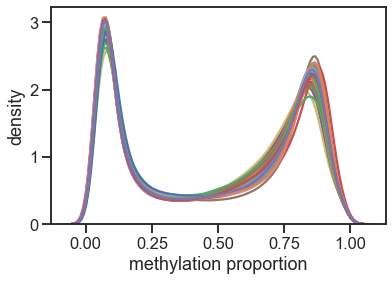

In [11]:
for sample in sample_list:

    sns.distplot(betas[sample], hist=False)

plt.xlabel("methylation proportion")
plt.ylabel("density")
plt.show()

# data labels

In [12]:
labels = pd.read_csv("GSE88890_labels.txt", delimiter="\t")

# average genome wide methylation 

In [13]:
averages = []

for sample in sample_list:
    averages.append(betas[sample].mean())

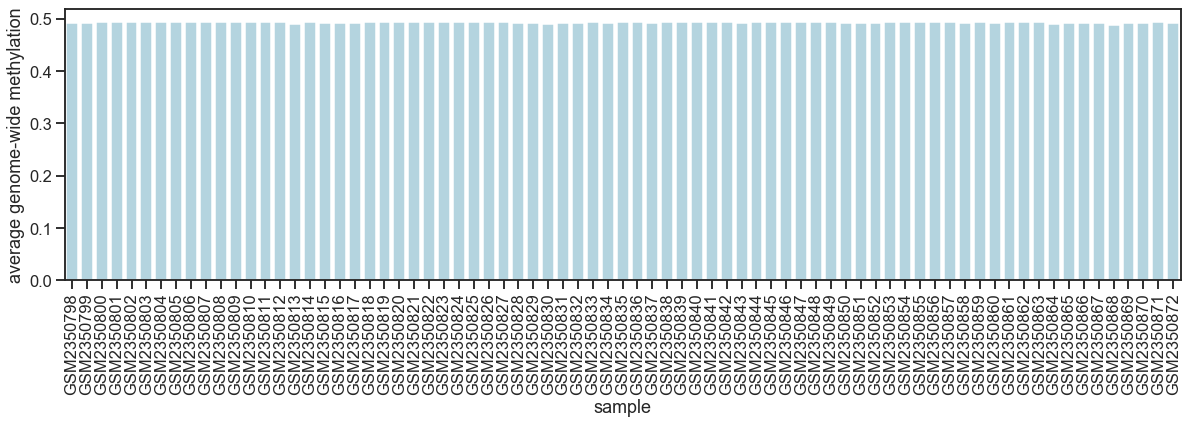

In [14]:
plt.rcParams["figure.figsize"] = (20,5)
sns.barplot(labels["ID_REF"], averages, color="lightblue")
plt.xticks(rotation=90)
plt.xlabel("sample")
plt.ylabel("average genome-wide methylation")
plt.show()

# Linear Regression

In [15]:
average_labels = pd.DataFrame({'average': averages,'group': labels["group"], 'sex':labels["sex"], "tissue":labels["tissue"]})

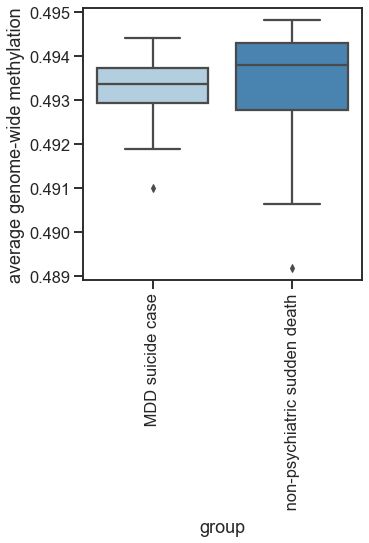

In [16]:
plt.figure(figsize=(5, 5))
sns.boxplot("group", "average", data=average_labels, palette=sns.color_palette("Blues", 2))
plt.xticks(rotation=90)
plt.ylabel("average genome-wide methylation")
plt.show()

In [17]:
average_labels["group_numeric"] = average_labels["group"].replace({' MDD suicide case':1, ' non-psychiatric sudden death':0})

In [18]:
X = average_labels["average"].values.T
Y = average_labels["group_numeric"].values.T

In [21]:
est = sm.Logit(Y, X)
results = est.fit()

Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3


In [22]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   75
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                            0
Date:                Tue, 08 Sep 2020   Pseudo R-squ.:               1.372e-06
Time:                        17:57:52   Log-Likelihood:                -51.979
converged:                       True   LL-Null:                       -51.979
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0543      0.468     -0.116      0.908      -0.972       0.863
==============================================================================
"""

# PCA

In [26]:
pca = decomposition.PCA(n_components=2)
principal_components = pca.fit_transform(betas.iloc[:, 1:].values.T)

In [27]:
pca.explained_variance_ratio_

array([0.25160282, 0.07412903])

In [28]:
pc_df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
pc_df["group"] = labels["group"]
pc_df["age"] = labels["age"]
pc_df["sex"] = labels["sex"]
pc_df["tissue"] = labels["tissue"]

## by status

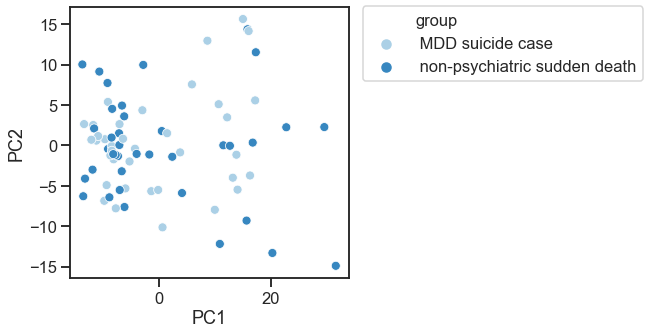

In [30]:
plt.figure(figsize=(5, 5))

sns.scatterplot("PC1", "PC2", hue="group", data=pc_df, palette=sns.color_palette("Blues", 2))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## by sex

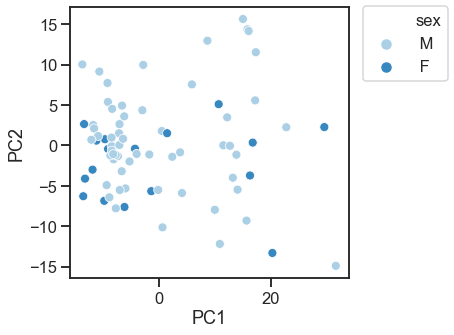

In [32]:
plt.figure(figsize=(5, 5))
sns.scatterplot("PC1", "PC2", hue="sex", data=pc_df, palette=sns.color_palette("Blues", 2))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## by tissue

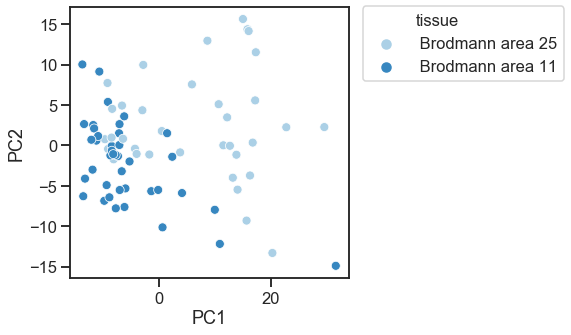

In [33]:
plt.figure(figsize=(5, 5))
sns.scatterplot("PC1", "PC2", hue="tissue", data=pc_df, palette=sns.color_palette("Blues", 2))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Feature Selection- k best

In [ ]:
broadman_25 = labels[labels["tissue"].str.contains("Brodmann area 25")]

In [ ]:
broadman_25_betas = betas[list(broadman_25["ID_REF"])]

In [ ]:
broadman_25["group_numeric"] = broadman_25["group"].replace({' MDD suicide case':1, ' non-psychiatric sudden death':0})

In [ ]:
X = broadman_25_betas.values.T
Y = broadman_25["group_numeric"].values.T

In [ ]:
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X, Y)

In [ ]:
features = fit.transform(X)

In [ ]:
features.shape

In [ ]:
features_df = pd.DataFrame(features)
features_df["group"] = list(broadman_25["group"])

In [ ]:
feature_number = 3
sns.boxplot("group", feature_number, data=features_df, palette=sns.color_palette("Blues", 2))
plt.xticks(rotation=90)
plt.ylabel("CpG feature")

# Regression with Selected Features

In [ ]:
est = sm.Logit(Y.T, features)
results = est.fit()

In [ ]:
results.summary()

# Regression controlling for covariates

In [ ]:
features_df["sex"] = list(broadman_25["sex"])

In [ ]:
features_df["sex"] = features_df["sex"].replace({" M":1, " F":0})

In [ ]:
features_df = features_df.drop("group", axis=1)

In [ ]:
features_df.values.shape

In [ ]:
est = sm.Logit(Y.T, features_df.values)
results = est.fit()

In [ ]:
results.summary()